<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In this notebook I download brand images from Google Images, clean them up, standardize them and experiment with data augmentation

In [36]:
# define global parameters:
good_ext  = [ '.jpeg', '.jpg', '.png' ] # only keep these extensions 

# data directories
data_raw = '../data/raw/'
data_preproc = '../data/preprocessed/'
data_proc = '../data/processed/'

# max image size after resizing
max_width, max_height = 300, 300

In [85]:
import shutil, sys, os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import cv2

In [7]:
## test: check that the google images downloader script works
from google_images_download import google_images_download   #importing the library
CHROMEDRIVER_PATH = '../../chromedriver'

# creating list of arguments - https://github.com/hardikvasa/google-images-download
arguments = {'keywords': 'Chase bank logo', 
             # 'output_directory': '../data/raw/',
             #'image_directory': 'chase',
             'no_download': True,
             'thumbnail': True,
             'chromedriver': CHROMEDRIVER_PATH,
             'no_numbering': True,
             'limit':5            
            }   
response = google_images_download.googleimagesdownload()   #class instantiation
paths = response.download(arguments)   #passing the arguments to the function
print(len(paths))


Item no.: 1 --> Item name = Chase bank logo
Evaluating...
Starting to Print Image URLS
Image URL: https://www.foodbanknyc.org/wp-content/uploads/Chase-Bank-logo.png
Printed url without downloading
Image URL: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSBi0KBNcCeVWPP9Ij8YQkNEKIOcUOwqOyX0sCp52M8meLznwz8
Printed url without downloading
Image URL: https://www.universityvillageriverside.com/wp-content/uploads/2018/03/chase-1.jpg
Printed url without downloading
Image URL: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1NPHl3GqhLt-r1HP1zWH0GUx77ojguJDDNO4noc_quFmQIMFFVQ
Printed url without downloading
Image URL: https://www.unthsc.edu/legends/wp-content/uploads/sites/34/Chase-Bank-Logos.png
Printed url without downloading
Image URL: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRN1megylDfmQCyaAgYU5MVsQqj6VtYRlApv_OaxTCxXaJ4YZYQpA
Printed url without downloading
Image URL: https://mir-s3-cdn-cf.behance.net/project_modules/disp/591c909436007.560dd3aa9aea2.jpg
Printed 

Define 10 sample brands and download up to 200 images each to the `data/raw` subfolder using the query **BRAND NAME logo**

In [8]:
# dictionary with brand names and corresponding folder they will be saved to
brands_dict = {'Adobe':'adobe', 'Apple Inc': 'apple', 'Bank of America':'boa', 'Chase Bank':'chase', 'Dropbox':'dropbox', 'Ebay':'ebay', 'Google':'google', 'Microsoft':'microsoft', 'Paypal': 'paypal', 'Wells Frago': 'wellsfargo' }

In [34]:
%%capture
strings = ['logo']
arguments = {#'keywords': 'logo, login, signin', 
             'output_directory': data_raw,
             #'image_directory': 'chase',
             'thumbnail': True,
             'chromedriver': CHROMEDRIVER_PATH,
             'no_numbering': True,
             'limit':200
            }
response = google_images_download.googleimagesdownload()   #class instantiation

all_paths = []
for k in brands_dict:
    arguments['keywords'] = ','.join(['{} {}'.format(k, s) for s in strings])
    arguments['image_directory'] = brands_dict[k]    
    paths = response.download(arguments)   #passing the arguments to the function
    all_paths.append(paths)
    #print(k, len(paths))
# print(len(paths))

In [35]:
[len(a[list(a.keys())[0]]) for a in all_paths]

[200, 103, 113, 200, 179, 200, 200, 98, 80, 131]

In [93]:
# clean up: only keep goo extensions
for folder in os.listdir(data_path):
    folder = os.path.join(data_path,folder)
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(folder):
        file = os.path.join(folder,file)
        ext = os.path.splitext(file)
        if ext[-1] not in good_ext:
            for e in good_ext:
                if file.endswith(e[1:]): # check for -png ending
                    os.rename(file, file+e)
                else: # remove file
                    os.remove(file)
                    break

Quick inspection: remove by hand all logos that are not correct. For each class, do it in large images directory, then remove them in ` - thumbnail` directory with following block

In [136]:
# for each hand-cleaned folder, remove corresponding thumbnails from other folder
# i,j =0,0
for folder in os.listdir(data_path):
    folder = os.path.join(data_path, folder)
    if not os.path.isdir(folder):
        continue
    if 'thumbnail' not in folder: 
        continue
    for file in sorted(os.listdir(folder)):
        # i+=1
        file_th = os.path.join(folder,file)
        file_name = ''.join(file_th.split('. ')[1:])
        corresponding_file = os.path.join(folder.split(' - thumbnail')[0], file_name)
        if not os.path.isfile(corresponding_file):
            os.remove(file_th)
            #j+=1
# print(i,j)

In [19]:
im = cv2.imread(file_out)[:, :, (2, 1, 0)] # RGB from BGR
h,w,d = im.shape

(181, 279, 3)

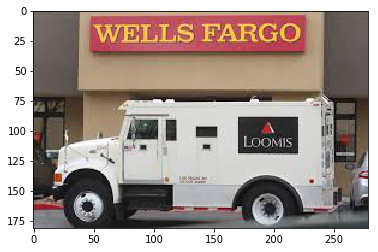

In [18]:
plt.imshow(im);

Take all images into `data/preprocessed/`, rename with sequential names

In [34]:
# move to preprocessed, give sequential names
for folder in sorted(os.listdir(data_path)):
    #folder = 
    folder_in = os.path.join(data_path, folder)
    folder_out = os.path.join(data_preproc, folder.split(' - thumbnail')[0])
    if not os.path.isdir(folder_in):
        continue
    if not os.path.isdir(folder_out):
        os.mkdir(folder_out)
    i = 0 if not 'thumbnail' in folder else i
    for file in os.listdir(folder_in):
        file_in = os.path.join(folder_in,file)
        ext = os.path.splitext(file_in)[-1]
        if ext not in good_ext:
            continue
        #new_name = str(hash(file) + sys.maxsize+1)+ext[-1] # add sys.maxsize to remap hash from [-2^N,2^N-1] to [0,2^(N+1)]
        new_name = folder.split(' - thumbnail')[0]+str(i)+ext
        file_out = os.path.join(folder_out, new_name)
        #print(file_out)
        i += 1
        shutil.copy(file_in, file_out)

Reshaping the images: for each image in `data/preprocessed`, if large image shrink and write into `data/processed`. Make two arrays with input and output image sizes

In [37]:
shapes_in = []
shapes_out = []
for folder in os.listdir(data_preproc):
    folder_out = os.path.join(data_proc, folder)
    folder = os.path.join(data_preproc, folder)
    
    if not os.path.isdir(folder):
        continue
    if not os.path.isdir(folder_out):
        os.mkdir(folder_out)
    
    for file in os.listdir(folder):
        if not any([file.endswith(ext) for ext in good_ext]):
            continue
        
        file_out = os.path.join(folder_out, file)
        file = os.path.join(folder, file)
        try: 
            im = cv2.imread(file)# NB: opencv is BGR, not RGB
            h,w,d = im.shape
        except: 
            continue
        
        
        # if image too large, resize it
        if h > max_height or w > max_width:
            asp_ratio = w/h
            if asp_ratio > 1: 
                w1, h1 = max_width, int(max_width/asp_ratio)
            else: 
                w1, h1 = int(asp_ratio * max_height), max_height
            im_out = cv2.resize(im, (w1,h1), interpolation = cv2.INTER_AREA)
        else:
            im_out = im
            h1, w1 = h,w
        
        cv2.imwrite(file_out, im_out)

        shapes_in.append([h,w])
        shapes_out.append([h1,w1])
        
shapes_in = np.array(shapes_in)
shapes_out = np.array(shapes_out)

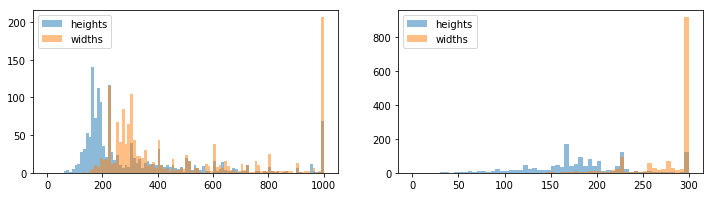

In [313]:
fig, axes = plt.subplots(1,2,figsize=(12,3))
axes[0].hist(np.clip(shapes_in[:,0], 0,1000), bins=range(0,1001,10), alpha=0.5, label='heights')
axes[0].hist(np.clip(shapes_in[:,1], 0,1000), bins=range(0,1001,10), alpha=0.5, label='widths')
# plt.hist(np.clip(np.sqrt(shapes_in[:,0]*shapes_in[:,1]), 0,1000), bins=range(0,1001,5), alpha=0.5, label='$\sqrt{area}$')
axes[0].legend();
axes[1].hist(shapes_out[:,0], bins=range(0,301,5), alpha=0.5, label='heights')
axes[1].hist(shapes_out[:,1], bins=range(0,301,5), alpha=0.5, label='widths')
axes[1].legend();

Data augmentation:
+ all images will be 300x300
+ if small logo, insert it at random position in image
+ small random jumps in HSV space, https://en.wikipedia.org/wiki/HSL_and_HSV
+ apply grayscale, invert black/white


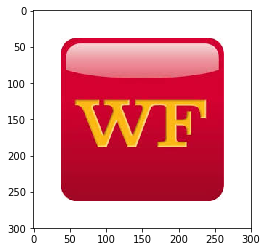

In [239]:
img1 = im[:,:,(2,1,0)]/255
plt.imshow(img1);

In [314]:
def hsv_walk(im, delta_hsv=(0.1, 0.2, 0.2)):
    """
    Given an input RGB image im, with values in [0,1] range, 
    take its HSV arrays and shift each component according to
    the array delta_hsv.
    NB: H is periodic in [0,1], S,V are clipped if go above 1.
    """
    
    h, s, v = np.moveaxis(mpl.colors.rgb_to_hsv(im), -1, 0)
    
    h = np.mod(h + delta_hsv[0], 1)
    s = np.clip(s + delta_hsv[1], 0, 1)
    v = np.clip(v + delta_hsv[2], 0, 1)
    
    return mpl.colors.hsv_to_rgb(np.moveaxis(np.array([h,s,v]),0,-1))

Verify the `hsv_walk` function behaves correctly: individually change each channel one at a time and plot difference with respect to original image

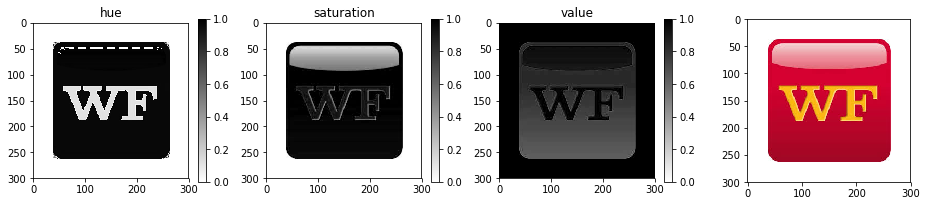

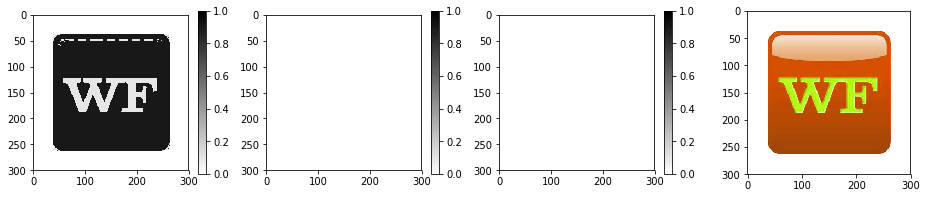

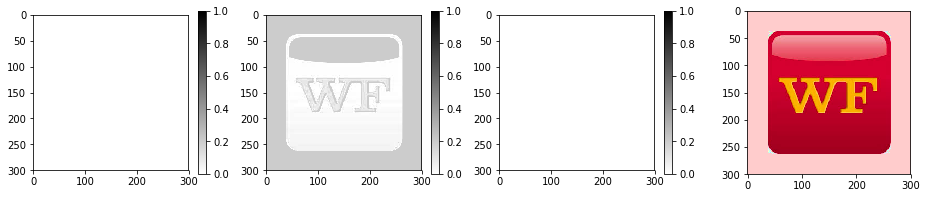

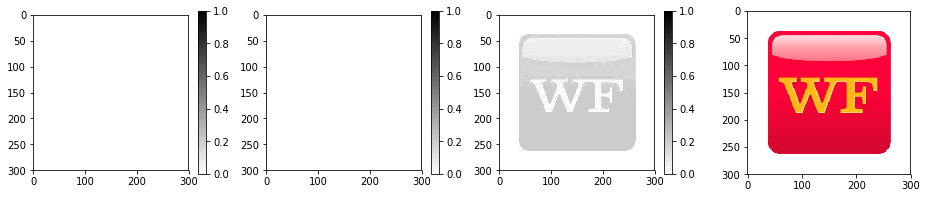

In [316]:
im_hsv = np.moveaxis(mpl.colors.rgb_to_hsv(img1),-1,0)
fig, axes = plt.subplots(1,4,figsize=(16,3))
for iax in range(3):
    img = axes[iax].imshow(im_hsv[iax], cmap='gray_r', vmin=0, vmax=1)
    cbar = plt.colorbar(img, ax=axes[iax])
    axes[iax].set_title(['hue','saturation','value'][iax])
    #cbar.set_label(['hue','saturation','value'][iax])
axes[3].imshow(img1)
plt.show()

img2 = hsv_walk(img1, (0.1,0,0))
fig, axes = plt.subplots(1,4,figsize=(16,3))
for iax in range(3):
    axes[iax].imshow(np.abs(np.moveaxis(mpl.colors.rgb_to_hsv(img1),-1,0)-np.moveaxis(mpl.colors.rgb_to_hsv(img2),-1,0))[iax], cmap='gray_r', vmin=0, vmax=1)
    cbar = plt.colorbar(img, ax=axes[iax])
axes[3].imshow(img2)

img2 = hsv_walk(img1, (0,0.2,0))
fig, axes = plt.subplots(1,4,figsize=(16,3))
for iax in range(3):
    axes[iax].imshow(np.abs(np.moveaxis(mpl.colors.rgb_to_hsv(img1),-1,0)-np.moveaxis(mpl.colors.rgb_to_hsv(img2),-1,0))[iax], cmap='gray_r', vmin=0, vmax=1)
    cbar = plt.colorbar(img, ax=axes[iax])
axes[3].imshow(img2)

img2 = hsv_walk(img1, (0,0,0.2))
fig, axes = plt.subplots(1,4,figsize=(16,3))
for iax in range(3):
    axes[iax].imshow(np.abs(np.moveaxis(mpl.colors.rgb_to_hsv(img1),-1,0)-np.moveaxis(mpl.colors.rgb_to_hsv(img2),-1,0))[iax], cmap='gray_r', vmin=0, vmax=1)
    cbar = plt.colorbar(img, ax=axes[iax])
axes[3].imshow(img2)
plt.show()

In [310]:
# parameters for data augmentation:
# change HSV for 20% of the time
# change to grayscale 10% of the time
thresh_hsv = 0.2
jump_hsv = (0.1,0.2,0.2)
thresh_rgb = 0.3


def augment(im):
    h,w,d = im.shape
    
    #if h < max_height or  w < max_width:
    pad = max(max_height - h, 0)
    padr = np.random.randint(pad+1)
    padh = ( pad - padr, padr )
    pad = max(max_width - w, 0)
    padr = np.random.randint(pad+1)
    padw = ( pad - padr, padr )
    
    im = np.pad(im, (padh, padw, (0,0)), mode='constant', constant_values=255)
    
    rand = np.random.random()
    if rand < RAND_HSV:
        im = hsv_walk(im, np.random.np.random.uniform(-1,1, 3) * jump_hsv )
    #elif rand < thresh_rgb:
        # GRAY SCALE: TO FINISH
    
                
    
    
    return im_hsv

In [79]:
max_width, max_height = 300, 300
x = [] # data array
y = [] # labels array

i=0
for folder in os.listdir(data_proc):
    folder = os.path.join(data_proc, folder)
    
    if not os.path.isdir(folder):
        continue

    for file in os.listdir(folder):
        file = os.path.join(folder, file)
        try: 
            im = cv2.imread(file)[:,:,(2,1,0)]# NB: opencv is BGR, not RGB
            h,w,d = im.shape
        except: 
            continue
        if h < max_height or w < max_width:
            pad = max_height - h
            padh = ( pad//2, pad//2 ) if pad%2==0 else ( pad//2+1, pad//2 )
            pad = max_width - w
            padw = ( pad//2, pad//2 ) if pad%2==0 else ( pad//2+1, pad//2 )
            pad_width = (padh, padw, (0,0))
            im = np.pad(im, pad_width, mode='constant', constant_values=255)
        x.append(im)
        y.append(i)
    i+=1
x = np.array(x)
y = np.array(y)

In [80]:
x.shape, y.shape

((1421, 300, 300, 3), (1421,))

In [82]:
import keras
keras.preprocessing.utils.to_categorical(y)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)